# Quick run

**Problem 2**: What is the optimal size of an electrolysis system for an 10 MW wind turbine offgrid?

WebIO._IJuliaInit()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 6.66646e+05
  Objective bound    : 6.66646e+05
  Relative gap       : 0.00000e+00
  Dual objective value : 6.66646e+05

* Work counters
  Solve time (sec)   : 1.52812e+00
  Barrier iterations : 0
  Node count         : 1

 Tech     | Size factor
 WT       | 1.0
 soec     | 8.3602
 boiler   | 0.7393
 EH       | 1.5932
 CT       | 0.38489


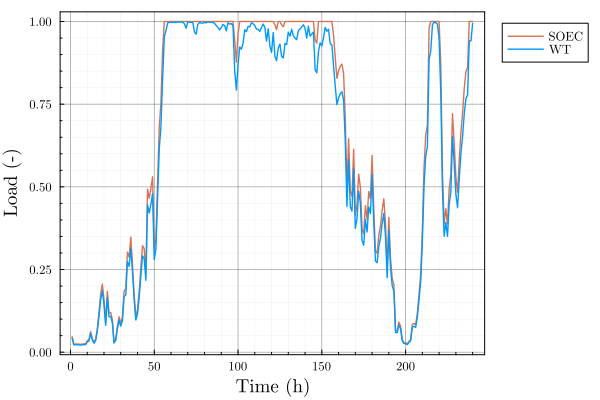

In [1]:
# Including functions
include("../../src/vivi.jl")

# Including technologies from previous example
include("./techLib.jl")

# Including extra packages
using CSV
using DataFrames

############################################
# Technologies
############################################

# Wind turbine
df = CSV.read("hourWind.csv",DataFrame)
HWT = round.(df.load*10E3,digits=3)
wt_out = [Resource("power",HWT,"kW",[[1]])]

i = 0.08
years = 20
hours = 8760
CRF = (i/(1-(1+i)^(-years)))/hours 
wt_cost = 20E6*CRF # EUR/h
wt = Tech("WT",[],wt_out,[],[1,1],wt_cost,[1,1])

# Including SOEC costs (for simplicity)
soec.cost = [2770*(1+0.235*3)*(888.61)*CRF,0]

############################################
# Inputs
############################################

water = Resource("water",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours]])
inputs = [water] # power is supplied by WT

############################################
# Outputs
############################################

c_h2 = 5 # EUR/kg
h2 = Resource("h2",[Inf for i=1:hours],"kg/h",[[c_h2 for i=1:hours]])
o2 = Resource("o2",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours]])
cut = Resource("power",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours]])

outputs = [h2,o2,cut]

############################################
# Problem solving
############################################

problem = Problem(inputs,[wt,soec,boiler,eh,ct],outputs)
answer = vivi(problem,solver="Gurobi",capex=true) # Gurobi solver is much faster

# Plotting first 10 days
plot(answer.processes[2].size[1:240]/maximum(answer.processes[2].size),label="SOEC")
plot!(HWT[1:240]/10E3,label="WT")
xaxis!("Time (h)")
yaxis!("Load (-)")

# Step-by-step

First we have to include the main functions of vivi. We can also reuse the models that we wrote in the last example:

In [2]:
# Including functions
include("../../src/vivi.jl")

# Including technologies from previous example
include("./techLib.jl")

Tech("CT", Any[Resource("power", Real[14.3], "kW", Vector{Real}[[0]])], Any[], HeatStruct[HeatStruct(1000.0, 298.0, 318.0)], Real[0.0, Inf], Real[0.0, 0.0, 0.0], Real[0, 1], Real[-1, 1], Real[1])

## Techs

The wind turbine can be model as a Tech that delivers a "power" Resource. This power can be represented by an array of quantities for each hour in a year:

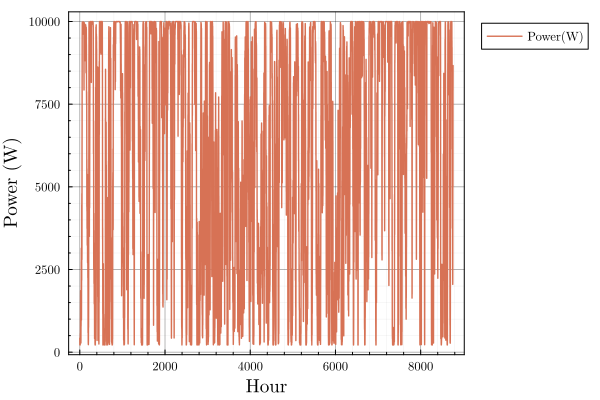

In [5]:
# Including extra packages
using CSV
using DataFrames

############################################
# Technologies
############################################

# Wind turbine
df = CSV.read("hourWind.csv",DataFrame)
HWT = round.(df.load*10E3,digits=3)
wt_out = [Resource("power",HWT,"kW",[[1]])]

plot(HWT,label="Power(W)") # Ploting the wind power profile
xaxis!("Hour")
yaxis!("Power (W)")

We also need to pay attention to the CAPEX of the wind turbine (assumed here as 20 MEUR / 10 MW). CAPEX has to be included in the same time resolution of the resources, so in this case the CAPEX unit is EUR/h.

In [7]:
i = 0.08
years = 20
hours = 8760
CRF = (i/(1-(1+i)^(-years)))/hours 
wt_cost = 20E6*CRF # EUR/h

232.53928955057208

The Tech syntax is a bit different to include the possibility of partial load and CAPEX:

        wt = Tech(type,inputs,outputs,heats,size,cost,loads)

* type : unique name
* inputs : Resource inputs
* outputs : Resource outputs
* heats : Heat transfers
* size: [min, max] sizes allowed
* cost: specific cost of Tech (in the same time resolution that the resources)
* loads: [min, max] loads allowed

In [8]:
wt = Tech("WT",[],wt_out,[],[1,1],wt_cost,[1,1])

Tech("WT", Any[], Any[Resource("power", Real[422.778, 222.922, 221.496, 225.441, 219.972, 217.2, 217.286, 231.432, 226.091, 314.469  …  2569.807, 2049.942, 2135.471, 3929.205, 6338.93, 5936.023, 5010.477, 8088.465, 7918.741, 8667.577], "kW", Vector{Real}[[1]])], HeatStruct[], Real[1, 1], Real[232.53928955057208, 0.0], Real[1, 1], Real[-1, 1], Real[1])

For this simple analysis we also need to assign a cost for the soec system. Costs are estimated by a linear function:

$$ c = a*size+b $$

So, assuming a cost of 2770 EUR/kw and three stack replacements (23.5% CAPEX) during the lifetime give us the following cost parameters:

In [9]:
# Including SOEC costs (for simplicity)
soec.cost = [2770*(1+0.235*3)*(888.61)*CRF,0]

2-element Vector{Float64}:
 48.795715923835466
  0.0

## Inputs and outputs

The inputs and outputs are very similar for this example. The main change is that now we have to assign a quantity for each time (1 to 8760 hour):

In [10]:
# Input
water = Resource("water",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours]])
inputs = [water] # power is supplied by WT

# Output
c_h2 = 5 # EUR/kg
h2 = Resource("h2",[Inf for i=1:hours],"kg/h",[[c_h2 for i=1:hours]])
o2 = Resource("o2",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours]])
cut = Resource("power",[Inf for i=1:hours],"kg/h",[[0 for i=1:hours]])

outputs = [h2,o2,cut]

3-element Vector{Resource}:
 Resource("h2", Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], "kg/h", Vector{Real}[[5, 5, 5, 5, 5, 5, 5, 5, 5, 5  …  5, 5, 5, 5, 5, 5, 5, 5, 5, 5]])
 Resource("o2", Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], "kg/h", Vector{Real}[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
 Resource("power", Real[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf  …  Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], "kg/h", Vector{Real}[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

## Problem and solution

In this case, since there are lots of variables, it is better to use the Gurobi solver. In addition, we should make it explicit to the solver that we would like to use the CAPEX estimations:

In [13]:
problem = Problem(inputs,[wt,soec,boiler,eh,ct],outputs)
answer = vivi(problem,solver="Gurobi",capex=true) # Gurobi solver is much faster

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 6.66646e+05
  Objective bound    : 6.66646e+05
  Relative gap       : 0.00000e+00
  Dual objective value : 6.66646e+05

* Work counters
  Solve time (sec)   : 1.49048e+00
  Barrier iterations : 0
  Node count         : 1

 Tech     | Size factor
 WT       | 1.0
 soec     | 8.3602
 boiler   | 0.7393
 EH       | 1.5932
 CT       | 0.38489


Problem(Any[Resource("water", Real[96.41730485163279, 50.83882896493122, 50.51362028160704, 51.41330349038255, 50.16606205342608, 49.53388921319142, 49.55350207908616, 52.77959046218838, 51.561540267493854, 71.71672470986691  …  586.0613961200911, 467.5027620693741, 487.0082133148393, 896.0810550917025, 1445.6346977448231, 1353.7491051977727, 1142.6722496466102, 1844.6276667346979, 1805.9209917217154, 1976.6979689908198], "kg/h", Vector{Real}[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])], Any[Tech("WT", Any[], Any[Resource("power", Real[422.778, 222.922, 221.496, 225.441, 219.972, 217.2, 217.286, 231.432, 226.091, 314.469  …  2569.807, 2049.942, 2135.471, 3929.205, 6338.93, 5936.023, 5010.477, 8088.465, 7918.741, 8667.577], "kW", Vector{Real}[[1]])], HeatStruct[], Real[1, 1], Real[232.53928955057208, 0.0], Real[1, 1], Real[-1, 1], Real[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]), Tech("soec", Any[Resource(

The solution gives the optimal sizes for the SOEC and auxiliary systems. The maximum revenue is estimated as **666,646 EUR/year** for the cost and wind power profile assumed.

What is interesting to observe is that the size of the SOEC system is slighly undersized, as it can be observed by plotting the load profiles of wind turbine and SOEC:

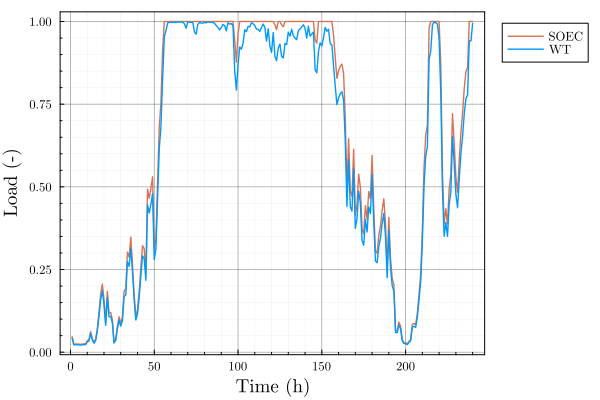

In [14]:
# Plotting first 10 days
plot(answer.processes[2].size[1:240]/maximum(answer.processes[2].size),label="SOEC")
plot!(HWT[1:240]/10E3,label="WT")
xaxis!("Time (h)")
yaxis!("Load (-)")

As it can be seen, the SOEC operates at slightly higher loads than the wind turbine, which can be explained by a small undersize of the SOEC system.

The optimization result may change depeding on the costs and wind profile. Different conditions can be evaluated with the same code.